Inverse problem for the Lorenz system with exogenous input

Example Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/lorenz.inverse.forced.html

In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
# We also want to define our three unknown variables, 𝜎, 𝜌 and 𝛽
# which will now be called C1, C2, and C3, respectivly. These variables are given an initial guess of 1.0.

C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)

In [5]:
# Now we can begin by creating a TimeDomain class.

geom = dde.geometry.TimeDomain(0, 3)

In [6]:
def Lorenz_system(x, y):
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

In [7]:
def boundary(_, on_initial):
    return on_initial

In [8]:
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

In [9]:
def gen_traindata():
    data = np.load("/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/Lorenz.npz")
    return data["t"], data["y"]

In [10]:
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

In [12]:
observe_t

array([[0.        ],
       [0.01071738],
       [0.06430429],
       [0.1226244 ],
       [0.20389738],
       [0.2774039 ],
       [0.36605932],
       [0.46484636],
       [0.57747023],
       [0.74410941],
       [0.87815709],
       [1.01220478],
       [1.15004686],
       [1.28280759],
       [1.42510765],
       [1.58172756],
       [1.75397377],
       [1.89764233],
       [2.04923335],
       [2.18795955],
       [2.37650218],
       [2.53747737],
       [2.69922368],
       [2.86424061],
       [3.        ]])

In [22]:
# Now that the problem is fully setup, we define the PDE as:

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

# Where num_domain is the number of points inside the domain, and num_boundary is
# the number of points on the boundary. anchors are extra points beyond num_domain
# and num_boundary used for training. auxiliary_var_function is the interpolation
# function of 𝑓(𝑡)
# we defined above.

In [23]:
# Next, we choose the network. Here, we use a fully connected neural network of
# depth 4 (i.e., 3 hidden layers) and width 40:
net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [24]:
external_trainable_variables =[C1, C2, C3]
# train adam
model.compile(
    "adam", lr=0.001, external_trainable_variables=external_trainable_variables
)


Compiling model...
'compile' took 0.002577 s



In [25]:
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

In [26]:
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])

Training model...



/Users/vassilis/anaconda3/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x2828182c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x2828182c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x2828182c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x281bbd940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x281bbd940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x281bbd940>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x281bbdb20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x281bbdb20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x281bbdb20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-14 14:41:24.449650: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.21e+00, 3.93e+00, 1.10e+00, 6.40e+01, 4.90e+01, 7.29e+02, 2.43e+01, 4.59e+01, 2.57e+02]    [5.21e+00, 3.93e+00, 1.10e+00, 6.40e+01, 4.90e+01, 7.29e+02, 2.43e+01, 4.59e+01, 2.57e+02]    []  
1000      [5.72e+00, 2.90e+00, 2.78e+00, 3.43e+01, 7.78e-03, 1.92e+00, 3.33e+01, 6.11e+00, 1.12e+01]    [5.72e+00, 2.90e+00, 2.78e+00, 3.43e+01, 7.78e-03, 1.92e+00, 3.33e+01, 6.11e+00, 1.12e+01]    []  
2000      [8.96e+00, 2.06e+00, 1.40e+00, 1.79e+01, 2.37e-01, 1.75e+00, 3.29e+01, 1.46e+01, 4.64e+00]    [8.96e+00, 2.06e+00, 1.40e+00, 1.79e+01, 2.37e-01, 1.75e+00, 3.29e+01, 1.46e+01, 4.64e+00]    []  
3000      [8.56e+00, 1.95e+00, 9.03e-01, 1.35e+01, 3.93e-01, 1.49e+00, 3.30e+01, 1.88e+01, 2.71e+00]    [8.56e+00, 1.95e+00, 9.03e-01, 1.35e+01, 3.93e-01, 1.49e+00, 3.30e+01, 1.88e+

Saving loss history to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/loss.dat ...
Saving training data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/train.dat ...
Saving test data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/test.dat ...


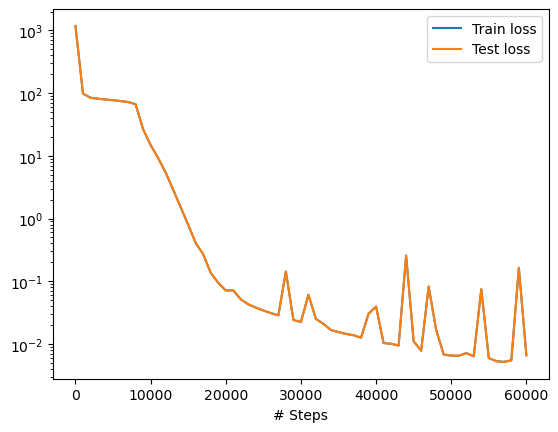

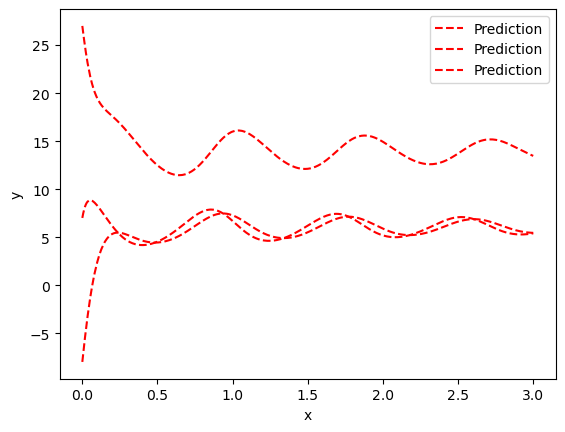

In [27]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [31]:
model.state_dict()

{'external_trainable_variable:0': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=10.01215>,
 'external_trainable_variable:1': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=14.999887>,
 'external_trainable_variable:2': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.6676342>,
 'denses.0.kernel': <tf.Variable 'fnn/dense/kernel:0' shape=(1, 40) dtype=float32, numpy=
 array([[ 0.62236774, -0.54023147,  0.92039114, -0.573312  , -0.4966742 ,
         -1.075558  ,  0.6040905 , -0.32251447,  1.3476703 , -0.88957566,
          1.580879  , -0.77059036, -0.3496533 ,  0.47907916,  0.7737956 ,
          0.33052757,  0.31312045, -0.3228225 , -0.3751157 ,  0.4415894 ,
          1.1147166 , -1.1168442 ,  0.61873764, -0.37807676, -0.25307655,
         -0.49188936, -0.989157  ,  1.1759607 ,  0.3887165 ,  0.6232528 ,
         -1.2080246 , -0.29233944,  0.07319437, -0.35678306, -0.32288244,
         -0.32675427,  1.0684747 , -0.3286898 , -0.26992536,  0.31620488]],
       dtyp

Compiling model...
'compile' took 0.010359 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
60000     [1.99e-03, 1.16e-03, 3.21e-03, 1.03e-05, 6.58e-08, 7.93e-06, 4.60e-05, 7.16e-05, 1.02e-04]    [1.99e-03, 1.16e-03, 3.21e-03, 1.03e-05, 6.58e-08, 7.93e-06, 4.60e-05, 7.16e-05, 1.02e-04]    []  


2023-09-14 14:42:43.832729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'DynamicStitch/indices_2' with dtype int32 and shape [40,40]
	 [[{{node DynamicStitch/indices_2}}]]
2023-09-14 14:42:43.832771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'DynamicStitch/indices_4' with dtype int32 and shape [40,40]
	 [[{{node DynamicStitch/indices_4}}]]


60274     [6.06e-04, 3.22e-04, 8.23e-04, 1.68e-09, 5.21e-07, 9.43e-08, 1.02e-05, 7.23e-06, 1.55e-05]    [6.06e-04, 3.22e-04, 8.23e-04, 1.68e-09, 5.21e-07, 9.43e-08, 1.02e-05, 7.23e-06, 1.55e-05]    []  

Best model at step 60274:
  train loss: 1.79e-03
  test loss: 1.79e-03
  test metric: []

'train' took 12.943334 s

Saving loss history to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/loss.dat ...
Saving training data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/train.dat ...
Saving test data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/example/test.dat ...


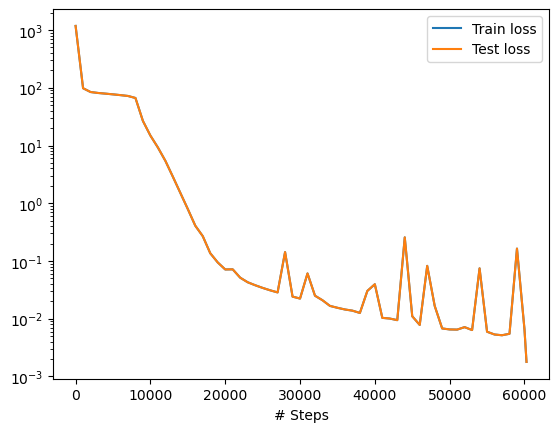

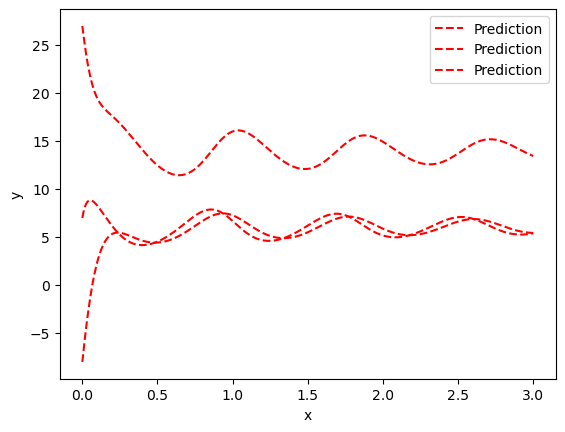

In [29]:
# train lbfgs
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [34]:
model.predict(tf.stack([[0],[10]]))

array([[-8.000041,  6.999278, 26.999693],
       [ 7.656982, 10.681408, 11.278773]], dtype=float32)